
# Summary: Directed Ball-Traversable Graph for Exact KNN Search

## ✅ Goal

We set out to design an **exact KNN algorithm** inspired by **Ball Prune** and **HNSW**, with a key constraint:

> 🔒 Ensure that for any ball $B_r(v)$, the subgraph induced by that ball is **traversable via directed edges from $v$ **.

This would let us:
- Explore only a **local region (ball)** around the current best match during KNN search,
- Prune all nodes outside the ball safely (using triangle inequality),
- While guaranteeing that we don't miss any true neighbors.

---

## 🧠 Core Ideas Implemented

### 1. **Directed Ball-Traversable Graph Construction**
We built a global graph where:
- Each node $v$ has outgoing edges to help reach all nodes in $B_r(v)$,
- Existing edges are **reused** to avoid redundancy,
- Only **new edges** are added when reachability is missing,
- This results in a **sparse**, efficient, and **ball-connected** graph.

**Definition (Center-Reachability of Metric Balls).**

Let $ G = (V, E) $ be a graph with vertices embedded in a metric space $ (X, d) $, where  
$ d: V \times V \to \mathbb{R}_{\ge 0} $ denotes the metric distance between nodes.

We say that $ G $ satisfies the **center-reachability property** if, for every pair of vertices $ v, w \in V $, there exists a path from $ v $ to $ w $ that is entirely contained within the ball:

$$
B_{d(v, w)}(v) := \{ u \in V \mid d(v, u) \le d(v, w) \}.
$$

### 2. **Reachability Check with BFS**
We created `bfs_within_ball` to:
- Traverse the graph starting from a node $v$,
- Only follow **outgoing edges**,
- And only if the nodes are within distance $r$.

This confirms if $B_r(v)$ is already fully traversable, and helps decide whether to add new edges.

---

## 🛠️ Tools and Testing Code Developed

- `generate_clustered_dataset`: Creates synthetic 2D clusters.
- `build_ball_traversable_graph`: Constructs the graph according to your rules.
- `bfs_within_ball`: Returns all nodes reachable within a ball.
- `plot_graph_2d`: Visualizes the full graph over 2D points.
- `test_bfs_within_ball`: Tests and visualizes ball-limited traversal from a given node.
- `sum(len(neighbors) for neighbors in graph.values())`: Counts total edges — simple and effective.

---

## 📈 Result

We now have a:
- Working prototype of your **custom proximity graph**,
- Fully functional and testable **ball-based expansion strategy**,
- Exact, localizable search foundation that supports **safe pruning**.


In [ ]:
Ball_Prune.ipynb

In [7]:
import numpy as np
from collections import deque, defaultdict
from Exact_efSearch_functions.construction import build_ball_traversable_graph

def generate_clustered_dataset(n_clusters=3, points_per_cluster=20, spread=0.1, dim=2):
    """Generate a dataset consisting of tight clusters in a d-dimensional space."""
    np.random.seed(0)
    dataset = []
    for _ in range(n_clusters):
        center = np.random.rand(dim) * 10
        points = np.random.randn(points_per_cluster, dim) * spread + center
        dataset.append(points)
    return np.vstack(dataset)

def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

# --- Run everything ---
# 1. Generate the dataset
dataset = generate_clustered_dataset(n_clusters=1, points_per_cluster=40, spread=0.2, dim=2)

# 2. Set max radius for ball
r_max = np.inf

# 3. Build the graph
graph, safe_radii_by_node = build_ball_traversable_graph(dataset)

# 4. Print number of edges
print("Total number of edges:", sum(len(neighbors) for neighbors in graph.values()))

Total number of edges: 108


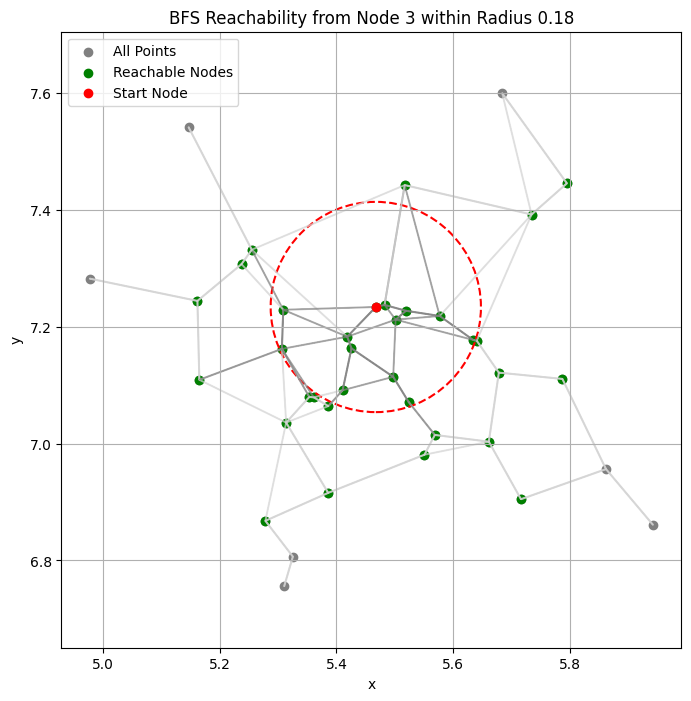

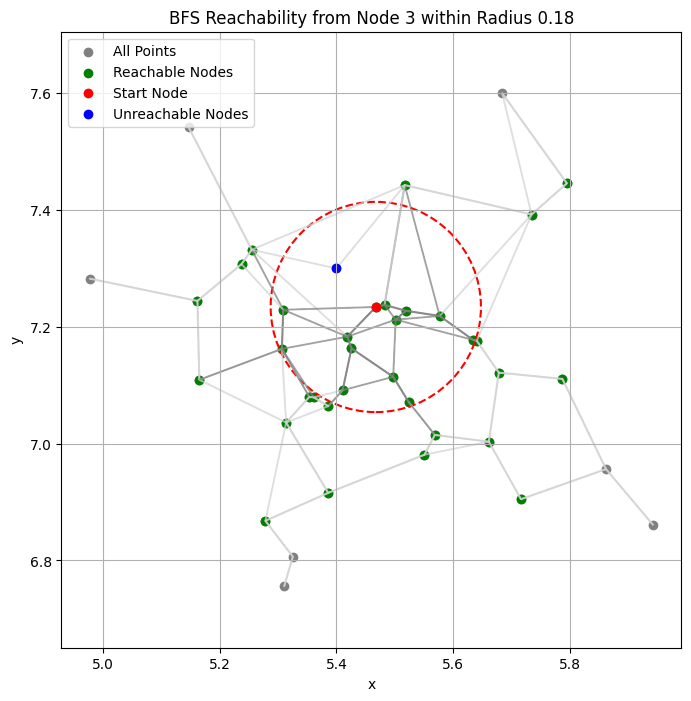

In [8]:
import matplotlib.pyplot as plt
from Exact_efSearch_functions.construction import bfs_within_ball

def test_bfs_within_ball(dataset, graph, v, radius, reachable):

    # Plot everything
    plt.figure(figsize=(8, 8))
    plt.scatter(dataset[:, 0], dataset[:, 1], c='gray', label='All Points')
    plt.scatter(dataset[list(reachable), 0], dataset[list(reachable), 1], c='green', label='Reachable Nodes')
    plt.scatter([dataset[v, 0]], [dataset[v, 1]], c='red', label='Start Node', zorder=5)

    # Draw radius circle around the root node
    circle = plt.Circle((dataset[v, 0], dataset[v, 1]), radius, color='red', fill=False, linestyle='--', linewidth=1.5)
    plt.gca().add_patch(circle)

    unreachable_in_ball = []

    # Show the traversal paths
    for node in graph:
        for neighbor in graph[node]:
            if neighbor in reachable and euclidean_distance(dataset[neighbor], dataset[v]) <= radius:
                edge_color = 'gray'
            else:
                edge_color = 'lightgray'
            x_coords = [dataset[node, 0], dataset[neighbor, 0]]
            y_coords = [dataset[node, 1], dataset[neighbor, 1]]
            plt.arrow(x_coords[0], y_coords[0],
                x_coords[1] - x_coords[0],
                y_coords[1] - y_coords[0],
                head_width=0.00, length_includes_head=True, fc=edge_color, ec=edge_color, alpha=0.6)

    for key in list(graph.keys()):
        if key not in reachable and euclidean_distance(dataset[key], dataset[v]) <= radius:
            unreachable_in_ball.append(key)
    if unreachable_in_ball:
        plt.scatter(dataset[list(unreachable_in_ball), 0], dataset[list(unreachable_in_ball), 1], c='blue', label='Unreachable Nodes')

    plt.title(f"BFS Reachability from Node {v} within Radius {radius}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage (after building the graph)
test_node = 3       # Pick a node index to test
test_radius = 0.18   # Same radius used to build the graph
reachable = bfs_within_ball(graph, dataset, test_node, test_radius)
test_bfs_within_ball(dataset, graph, test_node, test_radius, reachable)

unreachable_point = np.array([5.4,7.3])
untraversable_graph = graph
untraversable_graph[40] = [4,39]
untraversable_dataset = np.vstack([dataset,unreachable_point])
test_bfs_within_ball(untraversable_dataset, untraversable_graph, test_node, test_radius, reachable)



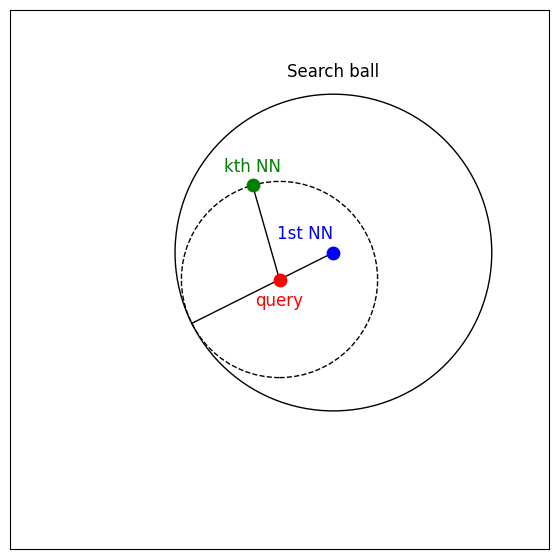

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define points
q = np.array([0.0, 0.0])           # query
v_best = np.array([0.2, 0.1])      # best NN (1st)
v_k = np.array([-0.1, 0.35])       # k-th NN

# Compute distances
d_best = np.linalg.norm(q - v_best)
d_k = np.linalg.norm(q - v_k)
R = d_best + d_k

# Compute extended point on line from v_best through q
direction = q - v_best
direction = direction / np.linalg.norm(direction)
endpoint = q + direction * d_k

# Plot setup
fig, ax = plt.subplots(figsize=(7, 7))

# Plot nodes (all circles) with color
ax.scatter(*q, color='red', label='query', s=80, zorder=5)
ax.scatter(*v_best, color='blue', label='1st nearest neighbor', s=80, zorder=5)
ax.scatter(*v_k, color='green', label='kth nearest neighbor', s=80, zorder=5)

# Add text labels at better positions
ax.text(q[0], q[1] - 0.1, 'query', color='red', fontsize=12, ha='center')
ax.text(v_best[0], v_best[1] + 0.05, '1st NN', color='blue', fontsize=12, ha='right')
ax.text(v_k[0], v_k[1] + 0.05, 'kth NN', color='green', fontsize=12, ha='center')

# Add circles
circle_k = plt.Circle(q, d_k, color='black', linestyle='--', fill=False)
circle_R = plt.Circle(v_best, R, color='black', linestyle='-', fill=False)
ax.add_patch(circle_k)
ax.add_patch(circle_R)

ax.text(0.2, 0.75, 'Search ball', color='black', fontsize=12, ha='center')

# Draw lines
ax.plot([q[0], v_k[0]], [q[1], v_k[1]], 'k-', linewidth=1)
ax.plot([v_best[0], endpoint[0]], [v_best[1], endpoint[1]], 'k-', linewidth=1)

# Clean layout
ax.set_aspect('equal')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_facecolor('white')
plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Define the plotting function again
def plot_ball_knn_graph_2d(dataset, query, knn_list, graph, ball_center, ball_radius):
    """
    Visualize the dataset with kNNs, query, pruning ball, and graph edges inside the ball.

    Args:
        dataset: np.ndarray of shape (n, 2)
        query: np.ndarray of shape (2,)
        knn_list: List of (distance, index) tuples
        graph: dict[int, List[int]]
        ball_center: np.ndarray of shape (2,)
        ball_radius: float
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot all dataset points
    ax.scatter(dataset[:, 0], dataset[:, 1], color='lightgray', label='Dataset')

    # Plot query
    ax.scatter(query[0], query[1], color='red', label='Query', zorder=5)

    # Plot kNNs
    knn_indices = [i for _, i in knn_list]
    ax.scatter(dataset[knn_indices, 0], dataset[knn_indices, 1], color='blue', label='Final kNNs')

    # Draw ball around v
    circle = plt.Circle((ball_center[0], ball_center[1]), ball_radius,
                        color='green', fill=False, linestyle='--', linewidth=2, label='Ball')
    ax.add_patch(circle)

    # Plot graph edges inside ball
    for u in range(len(dataset)):
        for v in graph.get(u, []):
            if np.linalg.norm(dataset[v] - ball_center) <= ball_radius:
                color = 'gray'
            else:
                color = 'lightgray'
            x_coords = [dataset[u][0], dataset[v][0]]
            y_coords = [dataset[u][1], dataset[v][1]]
            ax.plot(x_coords, y_coords, color=color, alpha=0.5)

    ax.set_title("Exact KNN Search with Ball and Local Graph Edges")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.axis('equal')
    ax.grid(True)
    ax.legend()
    plt.show()

Total number of edges in the convex graph: 304
Initial kNNs:
Index: 75, Distance: 0.0575
Index: 72, Distance: 0.0584
Index: 97, Distance: 0.0649
Index: 48, Distance: 0.0936
Index: 86, Distance: 0.2374
Number of vectors expanded in exact search: 18
Number of center jumps in exact search: 0
Brute Force FAISS Results:
Index: 75, Distance: 0.0575
Index: 72, Distance: 0.0584
Index: 97, Distance: 0.0649
Index: 87, Distance: 0.0775
Index: 48, Distance: 0.0936

Your Exact KNN Results (Ball Prune with BFS):
Index: 75, Distance: 0.0575
Index: 72, Distance: 0.0584
Index: 97, Distance: 0.0649
Index: 87, Distance: 0.0775
Index: 48, Distance: 0.0936

✅ Match: Your exact search matches brute-force FAISS.


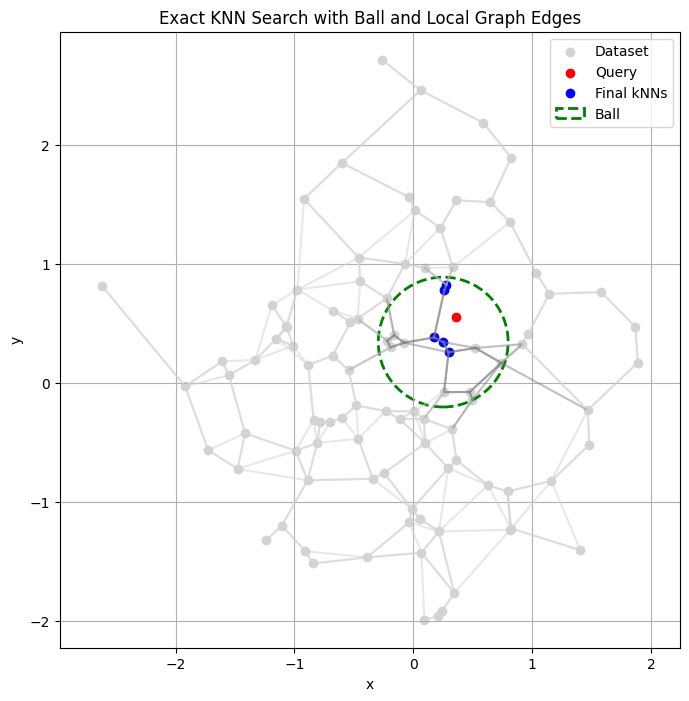

In [11]:
import faiss
import numpy as np
from Exact_efSearch_functions.query import bfs_within_ball_dynamic

# --- Create data and query ---
dim = 2
num_points = 100
k = 5
np.random.seed(42)

dataset = np.random.randn(num_points, dim).astype('float32')
query = np.random.randn(dim).astype('float32').reshape(1, -1)
graph, traversable_radii_by_node = build_ball_traversable_graph(dataset)

# Count total number of directed edges
num_edges = sum(len(neighbors) for neighbors in graph.values())
print(f"Total number of edges in the convex graph: {num_edges}")

# --- Build FAISS HNSW index ---
index = faiss.IndexHNSWFlat(dim, 32)  # 32 = M (max connections per node)
index.hnsw.efSearch = 1               # Set efSearch to a very small value
index.hnsw.efConstruction = 100
index.add(dataset)

# --- Get k approximate neighbors from FAISS ---
D, I = index.search(query, k)           # D: distances, I: indices
initial_knns = list(I[0])               # list of k initial indices
initial_dists = [d for d in D[0]]  # convert from squared to Euclidean

# Print initial kNNs
print("Initial kNNs:")
for dist, idx in [(D[0][i], I[0][i]) for i in range(k)]:
    print(f"Index: {idx}, Distance: {dist:.4f}")

# --- Choose root and compute fixed radius ---
v = initial_knns[0]                     # seed for BFS

expanded, exact_knn, jumps = bfs_within_ball_dynamic(
    graph=graph,
    dataset=dataset,
    root=v,
    k=k,
    query=query.flatten(),
    evaluated_set=set(),
    traversable_radii_by_node=traversable_radii_by_node
)

best_dist = exact_knn[0][0]
best_idx = exact_knn[0][1]
kth_dist = exact_knn[k-1][0]
ball_radius = np.sqrt(best_dist) + np.sqrt(kth_dist)      # static pruning radius

print(f"Number of vectors expanded in exact search: {len(expanded)}")
print(f"Number of center jumps in exact search: {jumps}")

# Build brute-force index using FAISS
brute_index = faiss.IndexFlatL2(dim)
brute_index.add(dataset)

# Perform brute-force KNN search
D_brute, I_brute = brute_index.search(query, k)

# Format brute-force results
brute_force_results = [(D_brute[0][i], I_brute[0][i]) for i in range(k)]

# Print brute-force results
print("Brute Force FAISS Results:")
for dist, idx in brute_force_results:
    print(f"Index: {idx}, Distance: {dist:.4f}")

# --- Comparison ---
if 'exact_knn' in locals():
    print("\nYour Exact KNN Results (Ball Prune with BFS):")
    for dist, idx in exact_knn:
        print(f"Index: {idx}, Distance: {dist:.4f}")

    brute_set = set(i for _, i in brute_force_results)
    exact_set = set(i for _, i in exact_knn)

    if brute_set == exact_set:
        print("\n✅ Match: Your exact search matches brute-force FAISS.")
    else:
        print("\n❌ Mismatch in results.")
        print(f"Brute-force indices: {sorted(brute_set)}")
        print(f"Exact search indices: {sorted(exact_set)}")
else:
    print("\n⚠️ exact_knn not defined — make sure to run your Ball Prune search first.")

if dim == 2:
    plot_ball_knn_graph_2d(
        dataset=dataset,
        query=query.flatten(),
        knn_list=exact_knn,
        graph=graph,
        ball_center=dataset[best_idx],    
        ball_radius=ball_radius       # from  ‖q - v‖ + R
    )

In [12]:
from Exact_efSearch_functions.construction import compute_empirical_geometry, compute_exact_knns, compute_percentile_ranks, compute_percentile_radius_by_node

knns_by_node = compute_exact_knns(dataset, k=k)
empirical_geometry = compute_empirical_geometry(dataset, traversable_radii_by_node, knns_by_node)
percentile_ranks = compute_percentile_ranks(empirical_geometry, p=0.95)
percentile_radii_by_node = compute_percentile_radius_by_node(dataset, percentile_ranks)

expanded, exact_knn, _ = bfs_within_ball_dynamic(
    graph=graph,
    dataset=dataset,
    root=v,
    k=k,
    query=query.flatten(),
    evaluated_set=set(),
    traversable_radii_by_node=traversable_radii_by_node,
    percentile_radii_by_node=percentile_radii_by_node
)

print(f"Number of vectors expanded in exact search: {len(expanded)}")

# Print brute-force results
print("Brute Force FAISS Results:")
for dist, idx in brute_force_results:
    print(f"Index: {idx}, Distance: {dist:.4f}")

# --- Comparison ---
if 'exact_knn' in locals():
    print("\nYour Exact KNN Results (Ball Prune with BFS):")
    for dist, idx in exact_knn:
        print(f"Index: {idx}, Distance: {dist:.4f}")

    brute_set = set(i for _, i in brute_force_results)
    exact_set = set(i for _, i in exact_knn)

    if brute_set == exact_set:
        print("\n✅ Match: Your exact search matches brute-force FAISS.")
    else:
        print("\n❌ Mismatch in results.")
        print(f"Brute-force indices: {sorted(brute_set)}")
        print(f"Exact search indices: {sorted(exact_set)}")
else:
    print("\n⚠️ exact_knn not defined — make sure to run your Ball Prune search first.")

Number of vectors expanded in exact search: 15
Brute Force FAISS Results:
Index: 75, Distance: 0.0575
Index: 72, Distance: 0.0584
Index: 97, Distance: 0.0649
Index: 87, Distance: 0.0775
Index: 48, Distance: 0.0936

Your Exact KNN Results (Ball Prune with BFS):
Index: 75, Distance: 0.0575
Index: 72, Distance: 0.0584
Index: 97, Distance: 0.0649
Index: 87, Distance: 0.0775
Index: 48, Distance: 0.0936

✅ Match: Your exact search matches brute-force FAISS.


C:\Users\u2470931\AppData\Local\Temp\ipykernel_30384\1140520445.py:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  percentile_ranks = compute_percentile_ranks(empirical_geometry, p=0.95)
